# Fethi Kahvecioğlu - 2019402051

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import train_test_split, GridSearchCV

# increase the max column displayed
pd.set_option('display.max_columns', 500)

In [2]:
data = pd.read_csv('match_data.csv')
data = data[(data["suspended"] == False) & (data["stopped"] == False)]

# Task 1: Evaluating Bookmakers' Draw Odds

**Objective**:
The task aims to evaluate the accuracy of bookmakers' implied probabilities for draws. By binning the implied draw probabilities, we calculate the actual probability of draws in those bins. The comparison between calculated probabilities and implied probabilities helps identify potential biases.

**Implementation**:
1. **Implied Probabilities**: Calculated `P(home win)`, `P(draw)`, and `P(away win)` from odds using P(x) = 1/odds.
2. **Normalization**: Normalized probabilities to ensure they sum to 1.
3. **Binning and Visualization**:
   - Discretized P(home win) - P(away win) values into bins.
   - Calculated the actual probabilities of draws for each bin.
   - Plotted P(home win) - P(away win) vs. P(draw) and analyzed discrepancies.

**Outcome**:
For most of the bins, the "fraction_draw", which is the calculated probability, are between the bin range. Visualizations suggest that the calculated and proposed probabilities are close. For some cases where the real probability is better (as in the [0, 0,2] bin), there is a winning chance in the long-run.

In [4]:
# Select relevant columns for odds and results
relevant_data = data[['1', 'X', '2', 'result']].dropna()

# Convert odds columns to numeric
relevant_data[['1', 'X', '2']] = relevant_data[['1', 'X', '2']].apply(pd.to_numeric, errors='coerce')

# Calculate implied probabilities
relevant_data['P(home win)'] = 1 / relevant_data['1']
relevant_data['P(draw)'] = 1 / relevant_data['X']
relevant_data['P(away win)'] = 1 / relevant_data['2']

# Normalize probabilities
total_prob = relevant_data['P(home win)'] + relevant_data['P(draw)'] + relevant_data['P(away win)']
relevant_data['P(home win, norm)'] = relevant_data['P(home win)'] / total_prob
relevant_data['P(draw, norm)'] = relevant_data['P(draw)'] / total_prob
relevant_data['P(away win, norm)'] = relevant_data['P(away win)'] / total_prob

# Define bins for P(draw)
bins = np.arange(0, 1.05, 0.05)
relevant_data['draw_bin'] = pd.cut(relevant_data['P(draw, norm)'], bins, right=True, include_lowest=True)

# Calculate fraction of games ending in a draw for each bin
bin_analysis = relevant_data.groupby('draw_bin').agg(
    total_games=('result', 'count'),
    draw_games=('result', lambda x: (x == "X").sum())
)
bin_analysis['fraction_draw'] = bin_analysis['draw_games'] / bin_analysis['total_games']

# Display bin analysis
display(bin_analysis)

,total_games,draw_games,fraction_draw
draw_bin,,,
"(-0.001, 0.05]",3894,129.0,0.033128
"(0.05, 0.1]",4671,305.0,0.065297
"(0.1, 0.15]",4808,560.0,0.116473
"(0.15, 0.2]",6167,1121.0,0.181774
"(0.2, 0.25]",7184,1828.0,0.254454
"(0.25, 0.3]",11173,3292.0,0.294639
"(0.3, 0.35]",7162,2349.0,0.327981
"(0.35, 0.4]",3139,1220.0,0.388659
"(0.4, 0.45]",1888,813.0,0.430614


In [5]:
# Function to analyze and visualize by half
def analyze_half(data_half, half_name):
    # Calculate P(home win) - P(away win) difference
    data_half['home_away_diff'] = data_half['P(home win, norm)'] - data_half['P(away win, norm)']

    # Define bins for home-away difference
    bins_diff = np.arange(-1, 1.1, 0.2)
    data_half['diff_bin'] = pd.cut(data_half['home_away_diff'], bins=bins_diff, right=True, include_lowest=True)

    # Aggregate by bins of home-away difference
    bin_analysis = data_half.groupby('diff_bin').agg(
        total_games=('result', 'count'),
        draw_games=('result', lambda x: (x == 'X').sum()),  # Assuming 'X' indicates a draw
        avg_proposed_draw=('P(draw, norm)', 'mean')
    )

    # Calculate real draw probability
    bin_analysis['real_draw_prob'] = bin_analysis['draw_games'] / bin_analysis['total_games']

    # Count games below and above real calculated probability for each bin
    bin_analysis['below_real_count'] = data_half.groupby('diff_bin').apply(
        lambda group: (group['P(draw, norm)'] < bin_analysis.loc[group.name, 'real_draw_prob']).sum()
    )
    bin_analysis['above_real_count'] = bin_analysis['total_games'] - bin_analysis['below_real_count']

    # Plot P(home win, norm) - P(away win, norm) as x-axis and P(draw) as y-axis for every point
    plt.figure(figsize=(14, 7))
    plt.scatter(data_half['home_away_diff'], data_half['P(draw, norm)'], alpha=0.5)
    plt.xlabel("P(home win, norm) - P(away win, norm)")
    plt.ylabel("Draw Probability")
    plt.title(f"P(home win) - P(away win) vs. P(draw) ({half_name})")
    plt.grid()
    plt.show()

    # Visualize P(home win) - P(away win) vs P(draw)
    plt.figure(figsize=(14, 7))
    plt.plot(bin_analysis.index.astype(str), bin_analysis['real_draw_prob'], label="Real Draw Probability", marker='o')
    plt.plot(bin_analysis.index.astype(str), bin_analysis['avg_proposed_draw'], label="Proposed P(draw)", marker='x')
    plt.xlabel("P(home win, norm) - P(away win, norm) Bins")
    plt.ylabel("Draw Probability")
    plt.title(f"Real vs. Proposed Draw Probabilities by Home-Away Difference ({half_name})")
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)
    plt.show()

    # Display the detailed bin analysis
    print(f"Bin Analysis ({half_name})")
    display(bin_analysis)

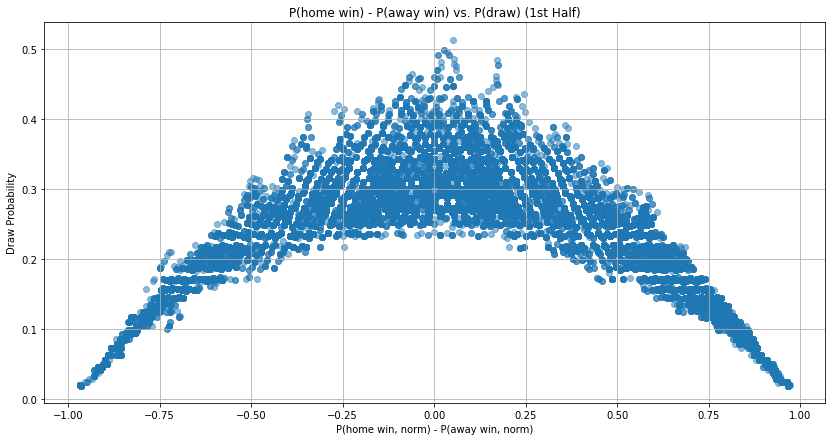

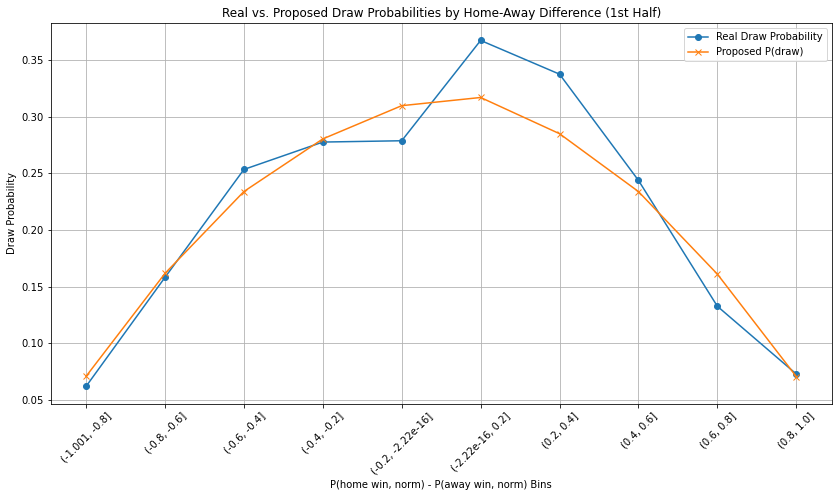

Bin Analysis (1st Half)


,total_games,draw_games,avg_proposed_draw,real_draw_prob,below_real_count,above_real_count
diff_bin,,,,,,
"(-1.001, -0.8]",664,41,0.070634,0.061747,230,434
"(-0.8, -0.6]",1322,209,0.161599,0.158094,615,707
"(-0.6, -0.4]",1929,489,0.233996,0.253499,1528,401
"(-0.4, -0.2]",3039,844,0.280511,0.277723,1710,1329
"(-0.2, -2.22e-16]",4120,1149,0.309891,0.278883,1027,3093
"(-2.22e-16, 0.2]",5716,2101,0.317124,0.367565,5153,563
"(0.2, 0.4]",4160,1405,0.285107,0.337740,3642,518
"(0.4, 0.6]",3494,852,0.233965,0.243847,2164,1330
"(0.6, 0.8]",3108,412,0.160991,0.132561,525,2583


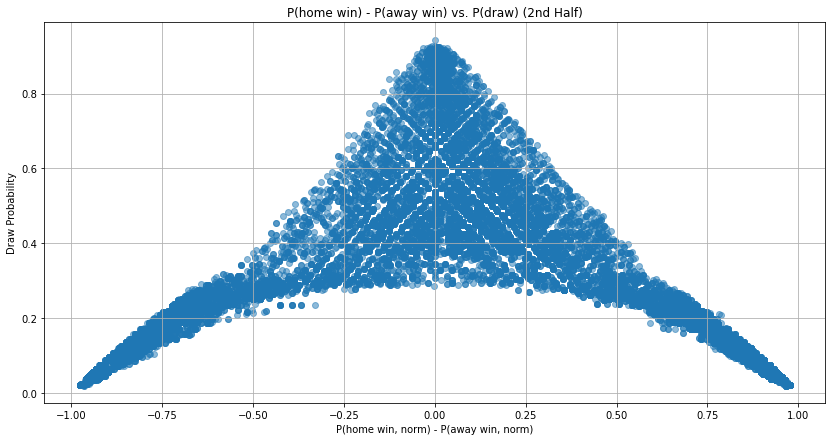

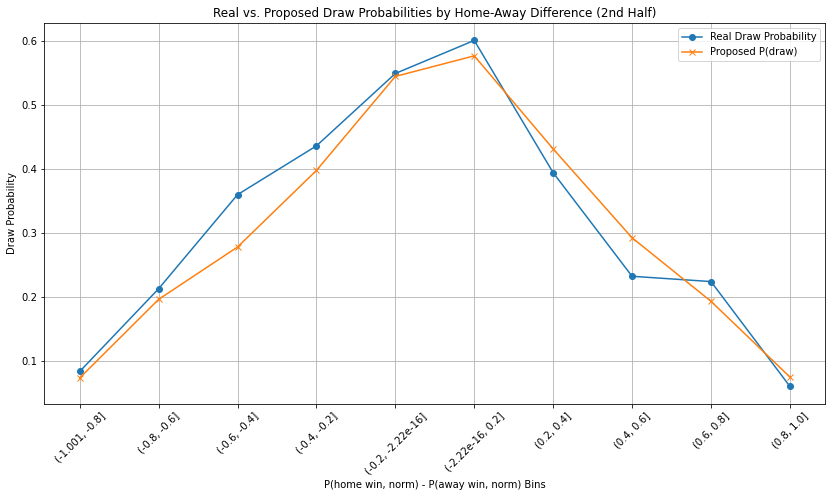

Bin Analysis (2nd Half)


,total_games,draw_games,avg_proposed_draw,real_draw_prob,below_real_count,above_real_count
diff_bin,,,,,,
"(-1.001, -0.8]",3552,297,0.073493,0.083615,2170,1382
"(-0.8, -0.6]",2289,487,0.196147,0.212757,1567,722
"(-0.6, -0.4]",1143,411,0.277857,0.359580,1088,55
"(-0.4, -0.2]",1120,488,0.397355,0.435714,752,368
"(-0.2, -2.22e-16]",2586,1419,0.544118,0.548724,1486,1100
"(-2.22e-16, 0.2]",4283,2571,0.576242,0.600280,2604,1679
"(0.2, 0.4]",1950,768,0.431004,0.393846,750,1200
"(0.4, 0.6]",1404,326,0.292296,0.232194,30,1374
"(0.6, 0.8]",2956,662,0.193143,0.223951,2434,522


In [6]:
# Add implied probabilities based on odds
data['P(home win)'] = 1 / data['1']
data['P(draw)'] = 1 / data['X']
data['P(away win)'] = 1 / data['2']

# Normalize probabilities
total_prob = data['P(home win)'] + data['P(draw)'] + data['P(away win)']
data['P(home win, norm)'] = data['P(home win)'] / total_prob
data['P(draw, norm)'] = data['P(draw)'] / total_prob
data['P(away win, norm)'] = data['P(away win)'] / total_prob

# Split the data by halves
first_half = data[data['halftime'] == '1st-half']
second_half = data[data['halftime'] == '2nd-half']

# Analyze for each half
analyze_half(first_half, "1st Half")
analyze_half(second_half, "2nd Half")


# Task 2: Handling Noisy Events

**Objective**:
Remove matches with specific noise-inducing events (e.g., goals in the 90th minute or red cards in the early game) to analyze their impact on predictions.

**Implementation**:
1. **Case 1: Late Goals**:
   - Identified matches where the final score matched late-game goals (after the 90th minute).
   - Removed 130 matches to exclude noise from such events.

2. **Case 2: Early Red Cards**:
   - Detected matches where a team received a red card within the first 20 minutes.
   - Removed 3 matches to reduce the bias introduced by early disadvantages.
   - Since there are 3 matches that fits to the case, the impact is small.

3. **Re-analysis**:
   - Recomputed the probabilities and re-plotted P(home win) - P(away win) vs. P(draw).
   - Compared results to evaluate how removing noisy matches impacts the observations.

**Outcome**:
The outcomes of the Task 1 and 2 are nearly the same but removing a few noisy matches improved the alignment between calculated and implied probabilities.

Removed matches due to late goals: 130
Removed matches due to early red cards: 3


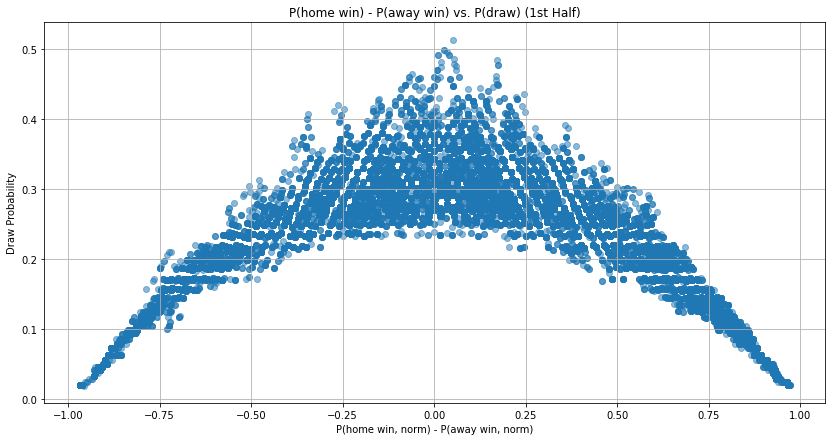

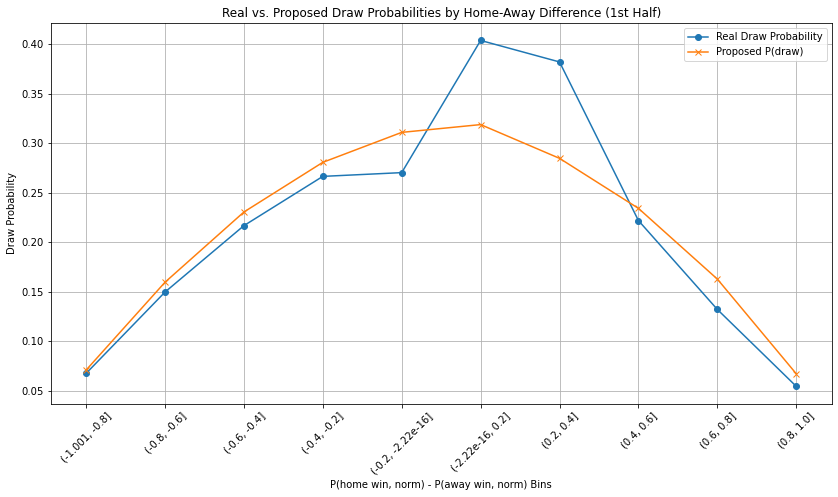

Bin Analysis (1st Half)


,total_games,draw_games,avg_proposed_draw,real_draw_prob,below_real_count,above_real_count
diff_bin,,,,,,
"(-1.001, -0.8]",624,42,0.070640,0.067308,281,343
"(-0.8, -0.6]",1251,187,0.159424,0.149480,468,783
"(-0.6, -0.4]",1685,365,0.230401,0.216617,563,1122
"(-0.4, -0.2]",2665,710,0.280610,0.266417,949,1716
"(-0.2, -2.22e-16]",3475,939,0.310894,0.270216,518,2957
"(-2.22e-16, 0.2]",4772,1927,0.318761,0.403814,4611,161
"(0.2, 0.4]",3222,1231,0.284649,0.382061,3174,48
"(0.4, 0.6]",2805,622,0.234099,0.221747,1138,1667
"(0.6, 0.8]",2577,340,0.162621,0.131936,362,2215


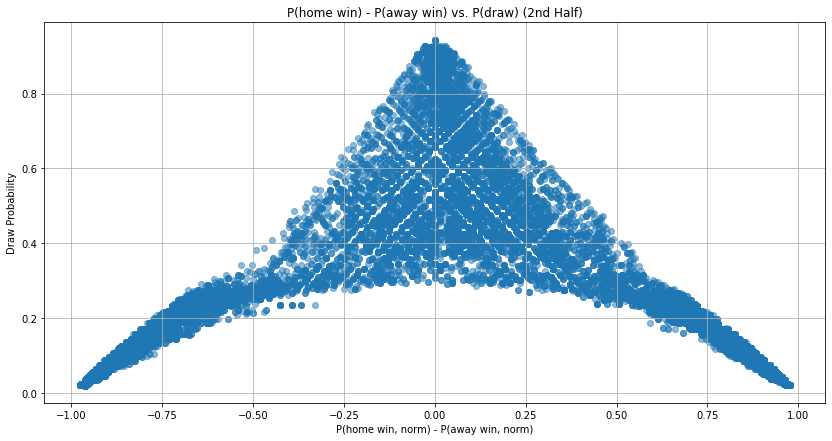

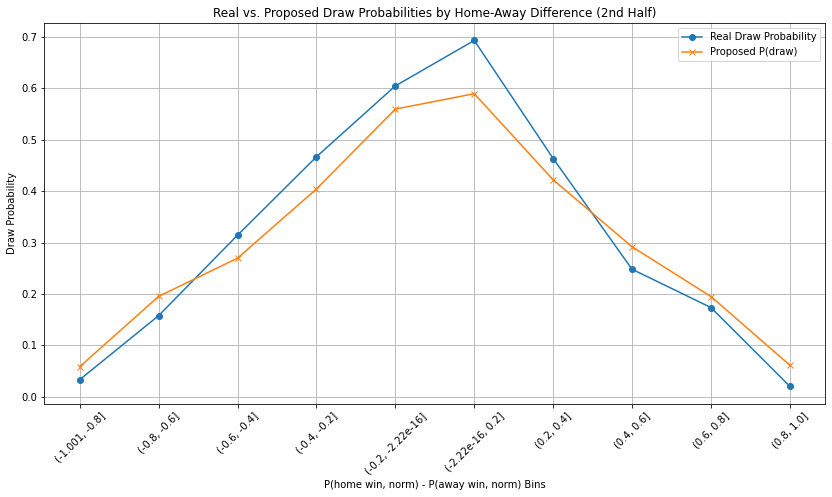

Bin Analysis (2nd Half)


,total_games,draw_games,avg_proposed_draw,real_draw_prob,below_real_count,above_real_count
diff_bin,,,,,,
"(-1.001, -0.8]",4479,149,0.058479,0.033266,1586,2893
"(-0.8, -0.6]",1964,310,0.195309,0.157841,354,1610
"(-0.6, -0.4]",967,304,0.269705,0.314374,910,57
"(-0.4, -0.2]",846,395,0.404250,0.466903,631,215
"(-0.2, -2.22e-16]",2361,1428,0.559714,0.604828,1543,818
"(-2.22e-16, 0.2]",3880,2690,0.589676,0.693299,2812,1068
"(0.2, 0.4]",1631,756,0.422100,0.463519,1117,514
"(0.4, 0.6]",1165,289,0.291835,0.248069,151,1014
"(0.6, 0.8]",2357,409,0.195013,0.173526,772,1585


In [7]:
# Reloading the data
data = pd.read_csv('match_data.csv')

# Add implied probabilities based on odds (Same as before)
data['P(home win)'] = 1 / data['1']
data['P(draw)'] = 1 / data['X']
data['P(away win)'] = 1 / data['2']

# Normalize probabilities
total_prob = data['P(home win)'] + data['P(draw)'] + data['P(away win)']
data['P(home win, norm)'] = data['P(home win)'] / total_prob
data['P(draw, norm)'] = data['P(draw)'] / total_prob
data['P(away win, norm)'] = data['P(away win)'] / total_prob

# Parse final goals from result column
data[['final_home_goals', 'final_away_goals']] = data['final_score'].str.split('-', expand=True).astype(int)

# Identify matches with late goals (Case 1)
late_goal_fixture_ids = []
for fixture_id, group in data.groupby('fixture_id'):
    # Track the cumulative goals
    valid_goal_time = None
    cumulative_home_goals = 0
    cumulative_away_goals = 0

    for idx in range(len(group)):
        row = group.iloc[idx]

        # Check for disallowed goals by comparing with the previous row
        if idx > 0:
            prev_row = group.iloc[idx - 1]
            if (row['Goals - home'] < prev_row['Goals - home'] or
                row['Goals - away'] < prev_row['Goals - away']):
                # Disallowed goal detected; skip this row
                continue

        # Update cumulative goals
        if row['Goals - home'] != cumulative_home_goals or row['Goals - away'] != cumulative_away_goals:
            cumulative_home_goals = row['Goals - home']
            cumulative_away_goals = row['Goals - away']

            # Check if cumulative goals match final result
            if (cumulative_home_goals == row['final_home_goals'] and
                cumulative_away_goals == row['final_away_goals']):
                # Save the first valid goal time
                if valid_goal_time is None:
                    valid_goal_time = (row['halftime'], row['minute'])

    # Flag match if last valid goal is after the 90th minute
    if valid_goal_time and valid_goal_time[0] == '2nd-half' and valid_goal_time[1] > 45:
        late_goal_fixture_ids.append(fixture_id)

# Identify matches with early red cards (Case 2)
data['redcard_event'] = (data['Redcards - away'] > 0) | (data['Redcards - home'] > 0)
data['is_early_redcard'] = data['redcard_event'] & (data['halftime'] == '1st-half') & (data['minute'] <= 20)
early_redcard_fixture_ids = data.loc[data['is_early_redcard'], 'fixture_id'].unique()

# Combine fixture IDs to remove
fixtures_to_remove = set(late_goal_fixture_ids).union(set(early_redcard_fixture_ids))

# Filter out the flagged matches
filtered_data = data[~data['fixture_id'].isin(fixtures_to_remove)]

# Count removed matches
removed_late_goal_count = len(late_goal_fixture_ids)
removed_early_redcard_count = len(early_redcard_fixture_ids)
print(f"Removed matches due to late goals: {removed_late_goal_count}")
print(f"Removed matches due to early red cards: {removed_early_redcard_count}")

# After detecting the late goals and early red cards, we can filter out the matches
data = data[(data["suspended"] == False) & (data["stopped"] == False)]

# Split the filtered data by halves
first_half = filtered_data[filtered_data['halftime'] == '1st-half']
second_half = filtered_data[filtered_data['halftime'] == '2nd-half']

# Function to analyze and visualize by half
analyze_half(first_half, "1st Half")
analyze_half(second_half, "2nd Half")

# Task 3: Decision Tree for Match Outcome Prediction

**Objective**:
Build a decision tree model to predict match outcomes based on match statistics and identify inefficiencies in bookmaker odds.

**Implementation**:
1. **Feature Engineering**:
   - Derived features like `goal_difference`, `possession_difference`, `shots_difference`, etc.
   - Handled missing values appropriately using forward-fill and zero-filling.

2. **Model Training**:
   - Used GridSearchCV to optimize decision tree hyperparameters.
   - Evaluated the best model using accuracy, precision, recall, and F1-score metrics.

3. **Market Inefficiency Analysis**:
   - Compared predicted probabilities from the decision tree with bookmakers' implied probabilities.
   - Calculated deviations to identify potential inefficiencies.

4. **Visualizations**:
   - Histograms of deviations for home wins, draws, and away wins.
   - Scatter plots of deviations vs. key features (e.g., `goal_difference`).


**Outcome**:
1. Key Features:
   - The goal_difference feature dominates the decision tree, which aligns with its strong correlation to match outcomes.
   - `possession_difference` and `dangerous_attacks_difference` frequently appear in the decision tree, indicating their influence on predicting the result.
2. Split Observations:
   - Matches with a higher `goal_difference` are heavily associated with either home wins (class 0) or away wins (class 2), depending on the sign of the difference.
   - Draws (class 1) are more likely when features like `possession_difference` and `fouls_difference` indicate balance between teams.
3. Depth and Interpretability:
   - The tree's depth (maximum of 7) balances between capturing complexity and remaining interpretable. Rules for specific scenarios (e.g., significant goal_difference) are clear.
4. Performance Metrics:
   - Overall Accuracy: 64%
   - Precision, Recall, and F1-scores:
   Home Wins (class 0): Precision = 0.64, Recall = 0.82, F1 = 0.72.
   Draws (class 1): Precision = 0.56, Recall = 0.38, F1 = 0.45.
   Away Wins (class 2): Precision = 0.71, Recall = 0.61, F1 = 0.66.
   - Observation:
   The model performs better at predicting wins (home or away) than draws. The lower recall for draws suggests challenges in identifying them accurately.

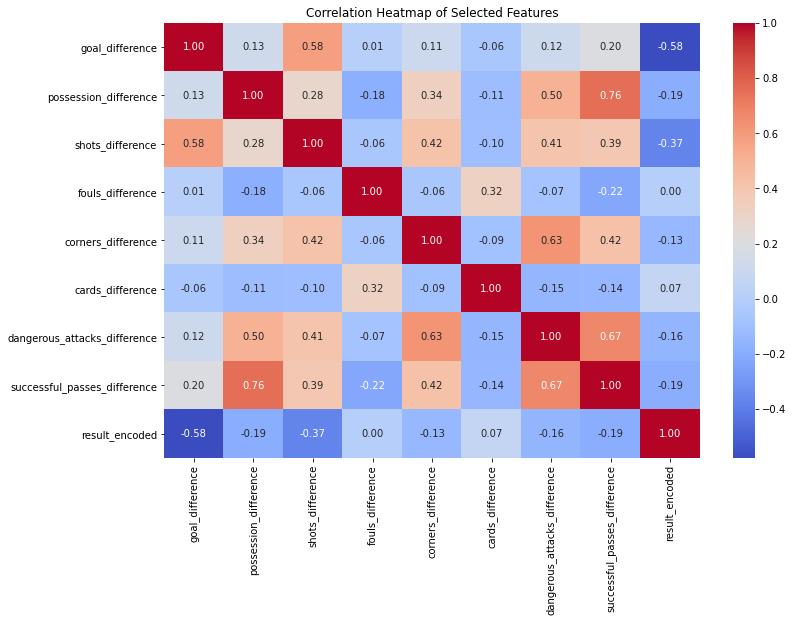

In [19]:
# Load the data
data = pd.read_csv('match_data.csv')

# Add implied probabilities based on odds
data['P(home win)'] = 1 / data['1']
data['P(draw)'] = 1 / data['X']
data['P(away win)'] = 1 / data['2']

# Normalize probabilities
total_prob = data['P(home win)'] + data['P(draw)'] + data['P(away win)']
data['P(home win, norm)'] = data['P(home win)'] / total_prob
data['P(draw, norm)'] = data['P(draw)'] / total_prob
data['P(away win, norm)'] = data['P(away win)'] / total_prob

# Feature engineering: Adding derived features
data['goal_difference'] = data['Goals - home'] - data['Goals - away']
data['possession_difference'] = data['Ball Possession % - home'] - data['Ball Possession % - away']
data['shots_difference'] = data['Shots On Target - home'] - data['Shots On Target - away']
data['fouls_difference'] = data['Fouls - home'] - data['Fouls - away']
data['corners_difference'] = data['Corners - home'] - data['Corners - away']
data['cards_difference'] = data['Yellowcards - home'] - data['Yellowcards - away']
data['dangerous_attacks_difference'] = data['Dangerous Attacks - home'] - data['Dangerous Attacks - away']
data['successful_passes_difference'] = data['Successful Passes - home'] - data['Successful Passes - away']

# Handle missing values using the proposed method
def handle_missing_values(group):
    group = group.copy()
    for col in group.columns:
        if group[col].isna().all():
            group[col].fillna(0, inplace=True)
        else:
            group[col].fillna(method='ffill', inplace=True)
            group[col].fillna(0, inplace=True)  # For the first row if still NaN
    return group

data = data.groupby('fixture_id').apply(handle_missing_values)

# Select features for decision tree based on domain knowledge
selected_features = [
    'goal_difference', 'possession_difference', 'shots_difference',
    'fouls_difference', 'corners_difference', 'cards_difference',
    'dangerous_attacks_difference', 'successful_passes_difference'
]

# Encode the result column for classification
data['result_encoded'] = data['result'].map({'1': 0, 'X': 1, '2': 2})

# Correlation heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = data[selected_features + ['result_encoded']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap of Selected Features")
plt.show()

In [20]:
# Train-Test Split
X = data[selected_features]
y = data['result_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Grid Search for Decision Tree
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print(f"Best Parameters: {best_params}")

# Evaluate the best model
y_pred = best_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Extract and display rules from the decision tree
rules = export_text(best_model, feature_names=selected_features)
print("Decision Tree Rules:")
print(rules)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2}
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.82      0.72      8413
           1       0.56      0.38      0.45      4917
           2       0.71      0.61      0.66      5854

    accuracy                           0.64     19184
   macro avg       0.64      0.60      0.61     19184
weighted avg       0.64      0.64      0.63     19184

Decision Tree Rules:
|--- goal_difference <= 0.50
|   |--- goal_difference <= -0.50
|   |   |--- goal_difference <= -1.50
|   |   |   |--- possession_difference <= 31.00
|   |   |   |   |--- fouls_difference <= 5.50
|   |   |   |   |   |--- successful_passes_difference <= 213.50
|   |   |   |   |   |   |--- fouls_difference <= -1.50
|   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |--- fouls_difference >  -1.50
|   |   |   |   |   | 

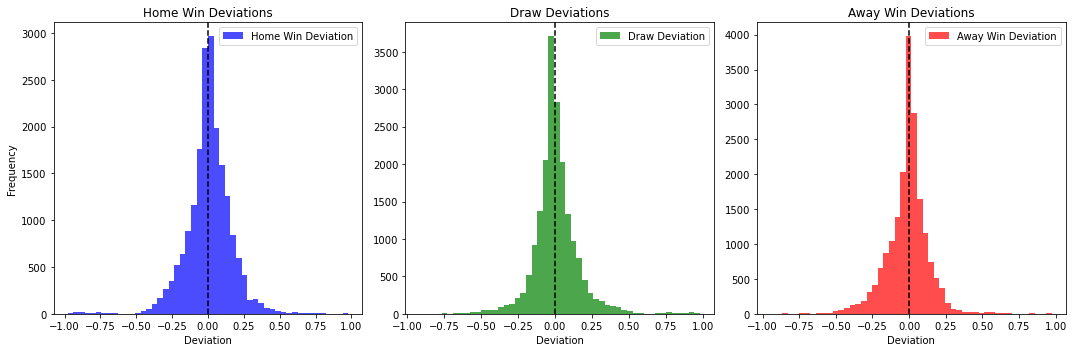

In [23]:
# Compare predicted probabilities to implied probabilities
predicted_probs = best_model.predict_proba(X_test)
comparison_df = X_test.copy()
comparison_df['true_result'] = y_test
comparison_df['predicted_result'] = y_pred

# Normalize predicted probabilities to ensure they sum to 1
predicted_probs = predicted_probs / predicted_probs.sum(axis=1, keepdims=True)
comparison_df['predicted_home_win_prob'] = predicted_probs[:, 0]
comparison_df['predicted_draw_prob'] = predicted_probs[:, 1]
comparison_df['predicted_away_win_prob'] = predicted_probs[:, 2]

# Add deviation columns
comparison_df['home_win_deviation'] = comparison_df['predicted_home_win_prob'] - data.loc[X_test.index, 'P(home win, norm)'].values
comparison_df['draw_deviation'] = comparison_df['predicted_draw_prob'] - data.loc[X_test.index, 'P(draw, norm)'].values
comparison_df['away_win_deviation'] = comparison_df['predicted_away_win_prob'] - data.loc[X_test.index, 'P(away win, norm)'].values

# Visualization: Deviations
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(comparison_df['home_win_deviation'], bins=50, color='blue', alpha=0.7, label='Home Win Deviation')
plt.axvline(0, color='black', linestyle='--')
plt.title("Home Win Deviations")
plt.xlabel("Deviation")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(comparison_df['draw_deviation'], bins=50, color='green', alpha=0.7, label='Draw Deviation')
plt.axvline(0, color='black', linestyle='--')
plt.title("Draw Deviations")
plt.xlabel("Deviation")
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(comparison_df['away_win_deviation'], bins=50, color='red', alpha=0.7, label='Away Win Deviation')
plt.axvline(0, color='black', linestyle='--')
plt.title("Away Win Deviations")
plt.xlabel("Deviation")
plt.legend()

plt.tight_layout()
plt.show()

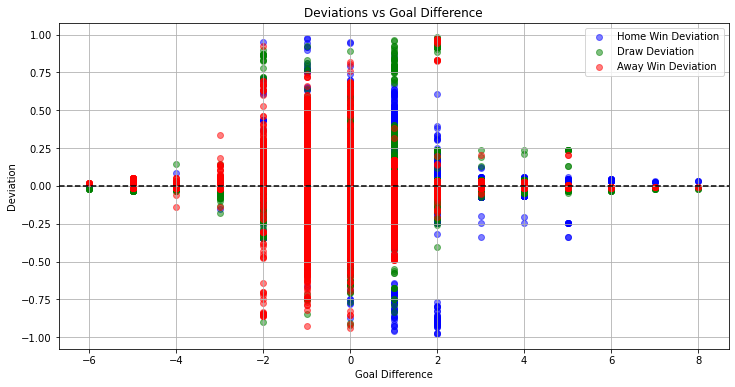

In [22]:
# Scatter plot of deviations vs goal_difference
plt.figure(figsize=(12, 6))
plt.scatter(comparison_df['goal_difference'], comparison_df['home_win_deviation'], color='blue', alpha=0.5, label='Home Win Deviation')
plt.scatter(comparison_df['goal_difference'], comparison_df['draw_deviation'], color='green', alpha=0.5, label='Draw Deviation')
plt.scatter(comparison_df['goal_difference'], comparison_df['away_win_deviation'], color='red', alpha=0.5, label='Away Win Deviation')
plt.axhline(0, color='black', linestyle='--')
plt.title("Deviations vs Goal Difference")
plt.xlabel("Goal Difference")
plt.ylabel("Deviation")
plt.legend()
plt.grid()
plt.show()